### Import data

In [15]:
import pickle
import numpy as np

def read_data(filename):
    x = pickle._Unpickler(open(filename, 'rb'))
    x.encoding = 'latin1'
    data = x.load()
    return data

files = []
for n in range(1, 33):
    s = ''
    if n < 10:
        s += '0'
    s += str(n)
    files.append(s)

labels = []
data = []
for i in files:
    filepath = "archive/data_preprocessed_python/s" + i + ".dat"
    d = read_data(filepath)
    labels.append(d['labels'])
    data.append(d['data'])



#### Reshape data

In [16]:

labels = np.array(labels)
data = np.array(data)
print(labels.shape)
print(data.shape)
labels = labels.reshape(1280, 4)
data = data.reshape(1280, 40, 8064)
print(labels.shape)
print(data.shape)
eeg_data = data[:,:32,:]
print(eeg_data.shape)


(32, 40, 4)
(32, 40, 40, 8064)
(1280, 4)
(1280, 40, 8064)
(1280, 32, 8064)


#### Encode labels

In [17]:
label_name = ["valence","arousal"]
labels_valence = []
labels_arousal = []

#9 classes
labels_valence = ["LOW" if la[0] < 3 else "MEDIUM" if la[0] < 6 else "HIGH" for la in labels] 
labels_arousal = ["LOW" if la[1] < 3 else "MEDIUM" if la[1] < 6 else "HIGH" for la in labels]

combined_labels = np.array([labels_valence[i] +'_' + labels_arousal[i] for i in range(len(labels_valence))]).reshape(-1,1)


from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
enc.fit(combined_labels)
enc.categories_
yData_enc = enc.transform(combined_labels).reshape(-1)

num_categories = len(np.unique(yData_enc))
num_categories

9

#### Model definition - EEGNet

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class EEGNet(nn.Module):
    def __init__(self, num_channels=32, num_samples=8064, num_classes=9, dropout_rate=0.5):
        super(EEGNet, self).__init__()
        
        # First block: Temporal Convolution
        self.temporal_conv = nn.Conv2d(1, 8, (1, 64), padding=(0, 32), bias=False)
        self.batchnorm1 = nn.BatchNorm2d(8)
        
        # Second block: Depthwise Convolution
        self.depthwise_conv = nn.Conv2d(8, 16, (num_channels, 1), groups=8, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(16)
        self.activation = nn.ELU()
        self.avgpool1 = nn.AvgPool2d((1, 4))
        self.dropout1 = nn.Dropout(dropout_rate)
        
        # Third block: Separable Convolutions
        self.separable_conv1 = nn.Conv2d(16, 16, (1, 16), padding=(0, 8), bias=False)
        self.batchnorm3 = nn.BatchNorm2d(16)
        self.separable_conv2 = nn.Conv2d(16, 16, (1, 1), bias=False)
        self.batchnorm4 = nn.BatchNorm2d(16)
        self.avgpool2 = nn.AvgPool2d((1, 8))
        self.dropout2 = nn.Dropout(dropout_rate)
        
        # Final Fully Connected Layer
        self.fc = nn.Linear(16 * (num_samples // (4 * 8)), num_classes)
    
    def forward(self, x):
        # Temporal Convolution
        x = self.temporal_conv(x)
        x = self.batchnorm1(x)
        x = x ** 2  # Squaring non-linearity
        
        # Depthwise Convolution
        x = self.depthwise_conv(x)
        x = self.batchnorm2(x)
        x = self.activation(x)
        x = self.avgpool1(x)
        x = self.dropout1(x)
        
        # Separable Convolutions
        x = self.separable_conv1(x)
        x = self.batchnorm3(x)
        x = self.separable_conv2(x)
        x = self.batchnorm4(x)
        x = self.activation(x)
        x = self.avgpool2(x)
        x = self.dropout2(x)
        
        # Flatten for Fully Connected layer
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x

# Function to calculate accuracy
def calculate_accuracy(outputs, targets):
    _, predicted = torch.max(outputs, 1)  # Get index of the max log-probability
    correct = (predicted == targets).sum().item()
    accuracy = correct / targets.size(0)
    return accuracy

# Instantiate the model
model = EEGNet(num_channels=32, num_samples=8064, num_classes=9, dropout_rate=0.5)

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

EEGNet(
  (temporal_conv): Conv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=False)
  (batchnorm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (depthwise_conv): Conv2d(8, 16, kernel_size=(32, 1), stride=(1, 1), groups=8, bias=False)
  (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ELU(alpha=1.0)
  (avgpool1): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
  (dropout1): Dropout(p=0.5, inplace=False)
  (separable_conv1): Conv2d(16, 16, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), bias=False)
  (batchnorm3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (separable_conv2): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (batchnorm4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avgpool2): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
  (dropout2): Dropout(

#### Model training

In [25]:
from torch.utils.data import DataLoader, TensorDataset

# Hyperparameters
learning_rate = 0.001
num_epochs = 10
batch_size = 32

xData = eeg_data
# Convert to PyTorch tensors
xData_tensor = torch.tensor(xData, dtype=torch.float32)
yData_tensor = torch.tensor(yData_enc, dtype=torch.long)  # For classification, labels should be long

# Split the data into training and validation sets
train_size = int(0.8 * len(xData_tensor))
val_size = len(xData_tensor) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(TensorDataset(xData_tensor, yData_tensor), [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Reinitialize the model, optimizer, and criterion
model = EEGNet(num_channels=32, num_samples=8064, num_classes=9, dropout_rate=0.5)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.unsqueeze(1)  # Add channel dimension

        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Step the scheduler
    scheduler.step()

    # Validation step
    with torch.no_grad():
        model.eval()
        val_loss = 0
        val_accuracy = 0
        for batch_X, batch_y in val_loader:
            batch_X = batch_X.unsqueeze(1)  # Add channel dimension
            val_outputs = model(batch_X)
            val_loss += criterion(val_outputs, batch_y).item()
            val_accuracy += calculate_accuracy(val_outputs, batch_y)

        val_loss /= len(val_loader)
        val_accuracy /= len(val_loader)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Save the model
torch.save(model.state_dict(), 'classifier_model.pth')


Epoch [1/10], Loss: 2.2177, Val Loss: 2.1095, Val Accuracy: 0.2227
Epoch [2/10], Loss: 1.9935, Val Loss: 2.0606, Val Accuracy: 0.2109
Epoch [3/10], Loss: 1.7062, Val Loss: 2.1222, Val Accuracy: 0.2148
Epoch [4/10], Loss: 1.4715, Val Loss: 2.1031, Val Accuracy: 0.2031
Epoch [5/10], Loss: 1.5769, Val Loss: 2.0928, Val Accuracy: 0.2383
Epoch [6/10], Loss: 1.2968, Val Loss: 2.0856, Val Accuracy: 0.2344
Epoch [7/10], Loss: 1.3498, Val Loss: 2.0841, Val Accuracy: 0.2500
Epoch [8/10], Loss: 1.5103, Val Loss: 2.0783, Val Accuracy: 0.2461
Epoch [9/10], Loss: 1.1609, Val Loss: 2.0811, Val Accuracy: 0.2305
Epoch [10/10], Loss: 1.2825, Val Loss: 2.0925, Val Accuracy: 0.2578


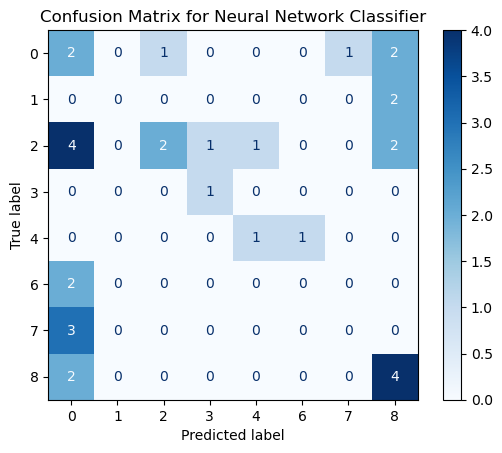

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Extract validation data from the DataLoader
X_val, y_val = next(iter(val_loader))
X_val = X_val.numpy()
y_val = y_val.numpy()

# Predict the labels for the test set using the neural network model
model.eval()
with torch.no_grad():
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
    y_pred_tensor = model(X_val_tensor)
    _, y_pred = torch.max(y_pred_tensor, 1)
    y_pred = y_pred.numpy()

# Compute the confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_val))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Neural Network Classifier')
plt.show()